In [1]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('../src')

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Import custom modules
from data_cleaning import FraudDataCleaner
from eda import FraudEDA
from geolocation import IPGeolocationMapper
from feature_engineering import FraudFeatureEngineer
from data_transformation import FraudDataTransformer

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# Step 1: Load and Clean Data
print("="*80)
print("STEP 1: DATA LOADING AND CLEANING")
print("="*80)

# Initialize cleaner
cleaner = FraudDataCleaner(verbose=True)

# Load fraud data
fraud_data_path = '../data/raw/Fraud_Data.csv'
df_fraud = cleaner.load_data(fraud_data_path)

# Display initial info
print(f"\n📊 Dataset Information:")
print(f"Shape: {df_fraud.shape}")
print(f"Columns: {df_fraud.columns.tolist()}")
print(f"\nSample data:")
print(df_fraud.head())

# Comprehensive cleaning
df_fraud_clean = cleaner.clean_fraud_data(df_fraud)

# Generate cleaning report
cleaning_report = cleaner.generate_cleaning_report()

STEP 1: DATA LOADING AND CLEANING
✓ Dataset loaded: 151,112 rows, 11 columns
✓ Memory usage: 63.81 MB

📊 Dataset Information:
Shape: (151112, 11)
Columns: ['user_id', 'signup_time', 'purchase_time', 'purchase_value', 'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class']

Sample data:
   user_id          signup_time        purchase_time  purchase_value  \
0    22058  2015-02-24 22:55:49  2015-04-18 02:47:11              34   
1   333320  2015-06-07 20:39:50  2015-06-08 01:38:54              16   
2     1359  2015-01-01 18:52:44  2015-01-01 18:52:45              15   
3   150084  2015-04-28 21:13:25  2015-05-04 13:54:50              44   
4   221365  2015-07-21 07:09:52  2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class  
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0  
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  
3  ATGTXK


STEP 2: EXPLORATORY DATA ANALYSIS (EDA)


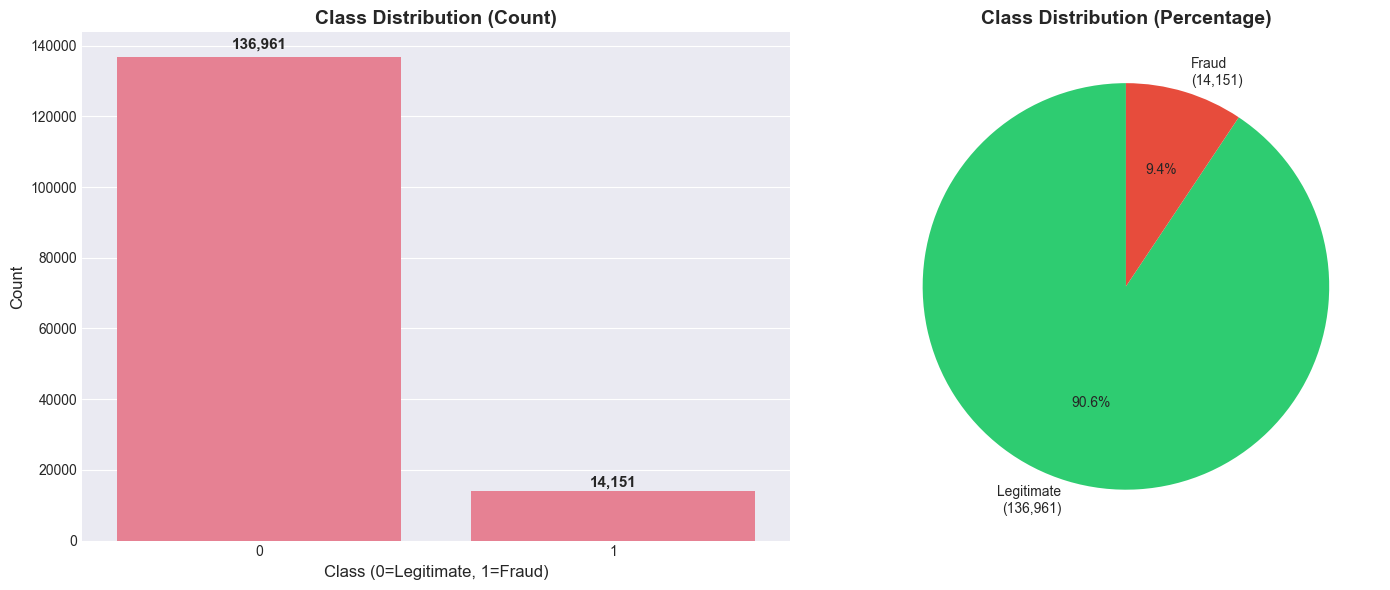


CLASS DISTRIBUTION ANALYSIS
Total samples: 151,112
Legitimate transactions: 136,961 (90.64%)
Fraudulent transactions: 14,151 (9.36%)
Imbalance ratio: 9.68:1
Fraud rate: 9.3646%

UNIVARIATE ANALYSIS

📊 NUMERICAL FEATURES (5):
                   count          mean           std        min           50%  \
user_id         151112.0  2.001710e+05  1.153693e+05      2.000  1.999580e+05   
purchase_value  151112.0  3.693500e+01  1.832300e+01      9.000  3.500000e+01   
age             151112.0  3.314100e+01  8.618000e+00     18.000  3.300000e+01   
ip_address      151112.0  2.152145e+09  1.248497e+09  52093.497  2.154770e+09   
class           151112.0  9.400000e-02  2.910000e-01      0.000  0.000000e+00   

                         max  skewness  kurtosis  
user_id         4.000000e+05     0.000    -1.197  
purchase_value  1.540000e+02     0.670     0.138  
age             7.600000e+01     0.425    -0.173  
ip_address      4.294850e+09    -0.007    -1.211  
class           1.000000e+00    

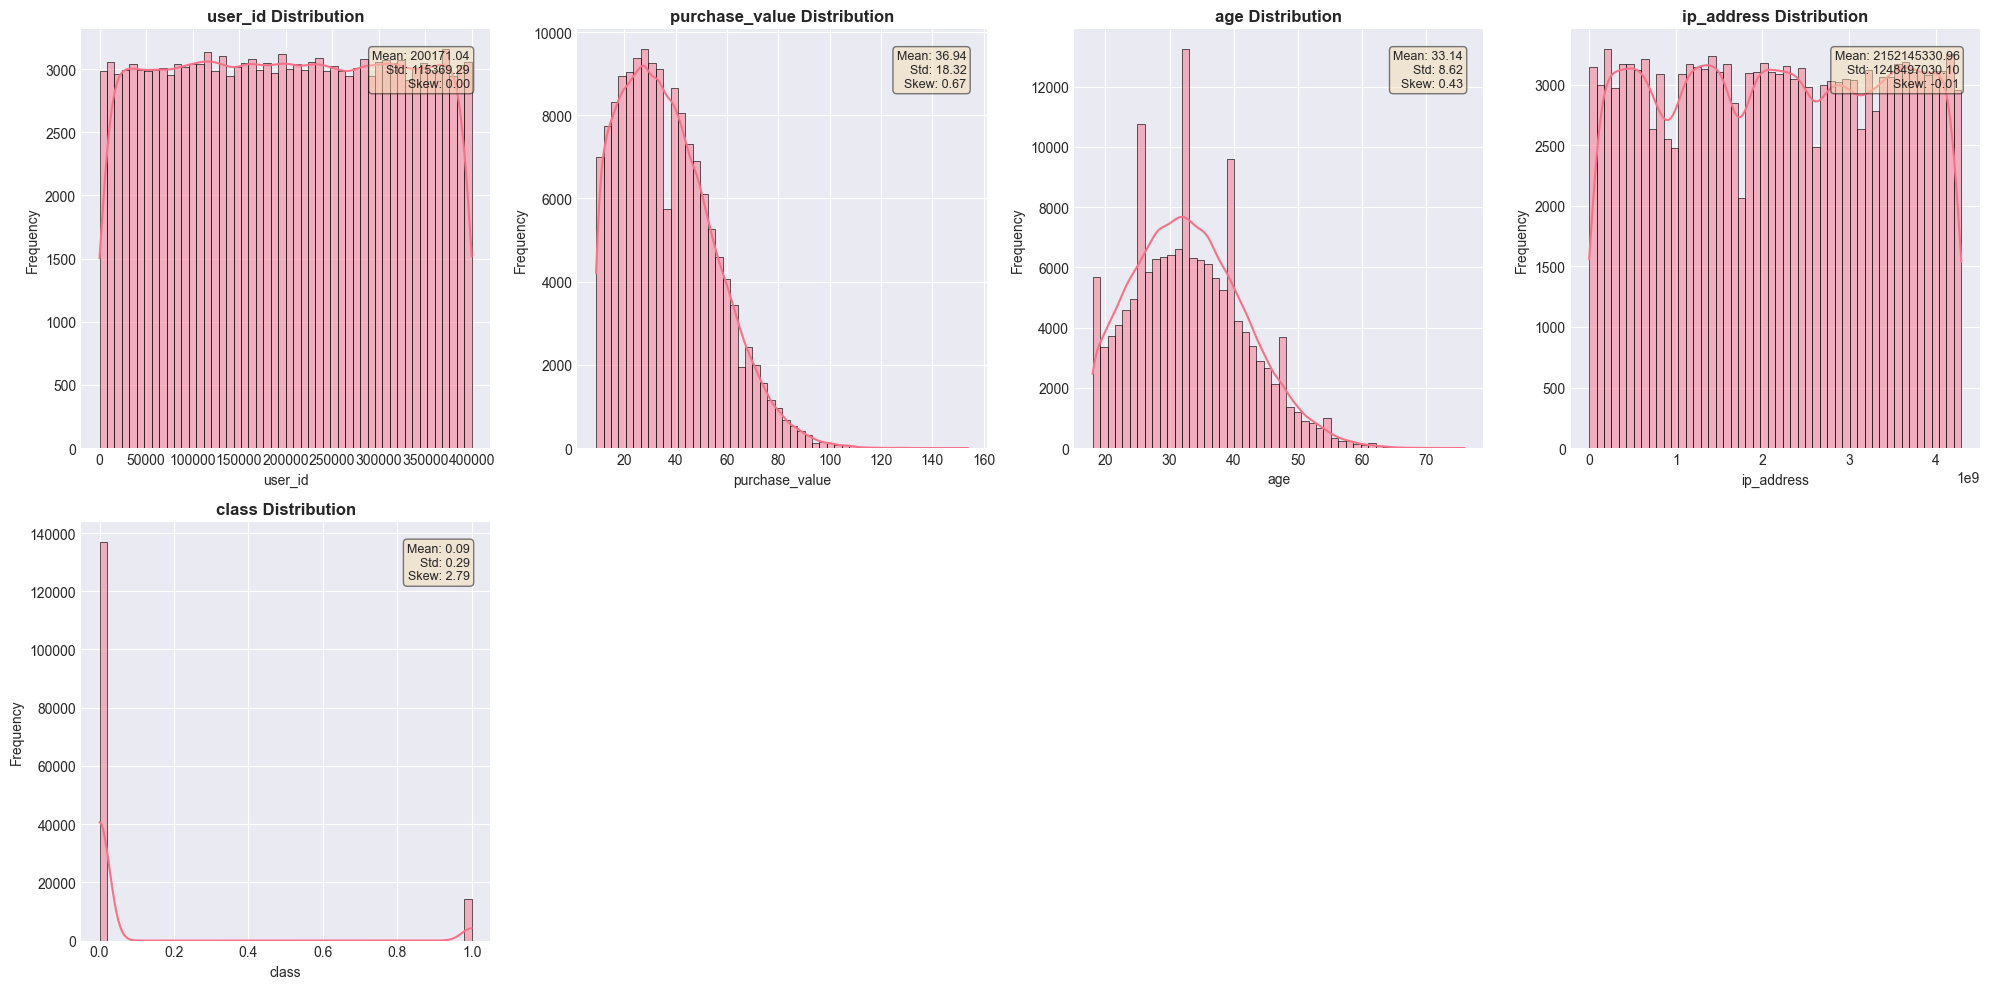


📈 CATEGORICAL FEATURES (6):
              unique_values         top_category top_count top_percentage
signup_time          151112  2015-02-24 22:55:49         1       0.000662
purchase_time        150679  2015-06-08 09:42:04         3       0.001985
device_id            137956        CQTUVBYIWWWBC        20       0.013235
source                    3                  SEO     60615      40.112632
browser                   5               Chrome     61432       40.65329
sex                       2                    M     88293      58.428847


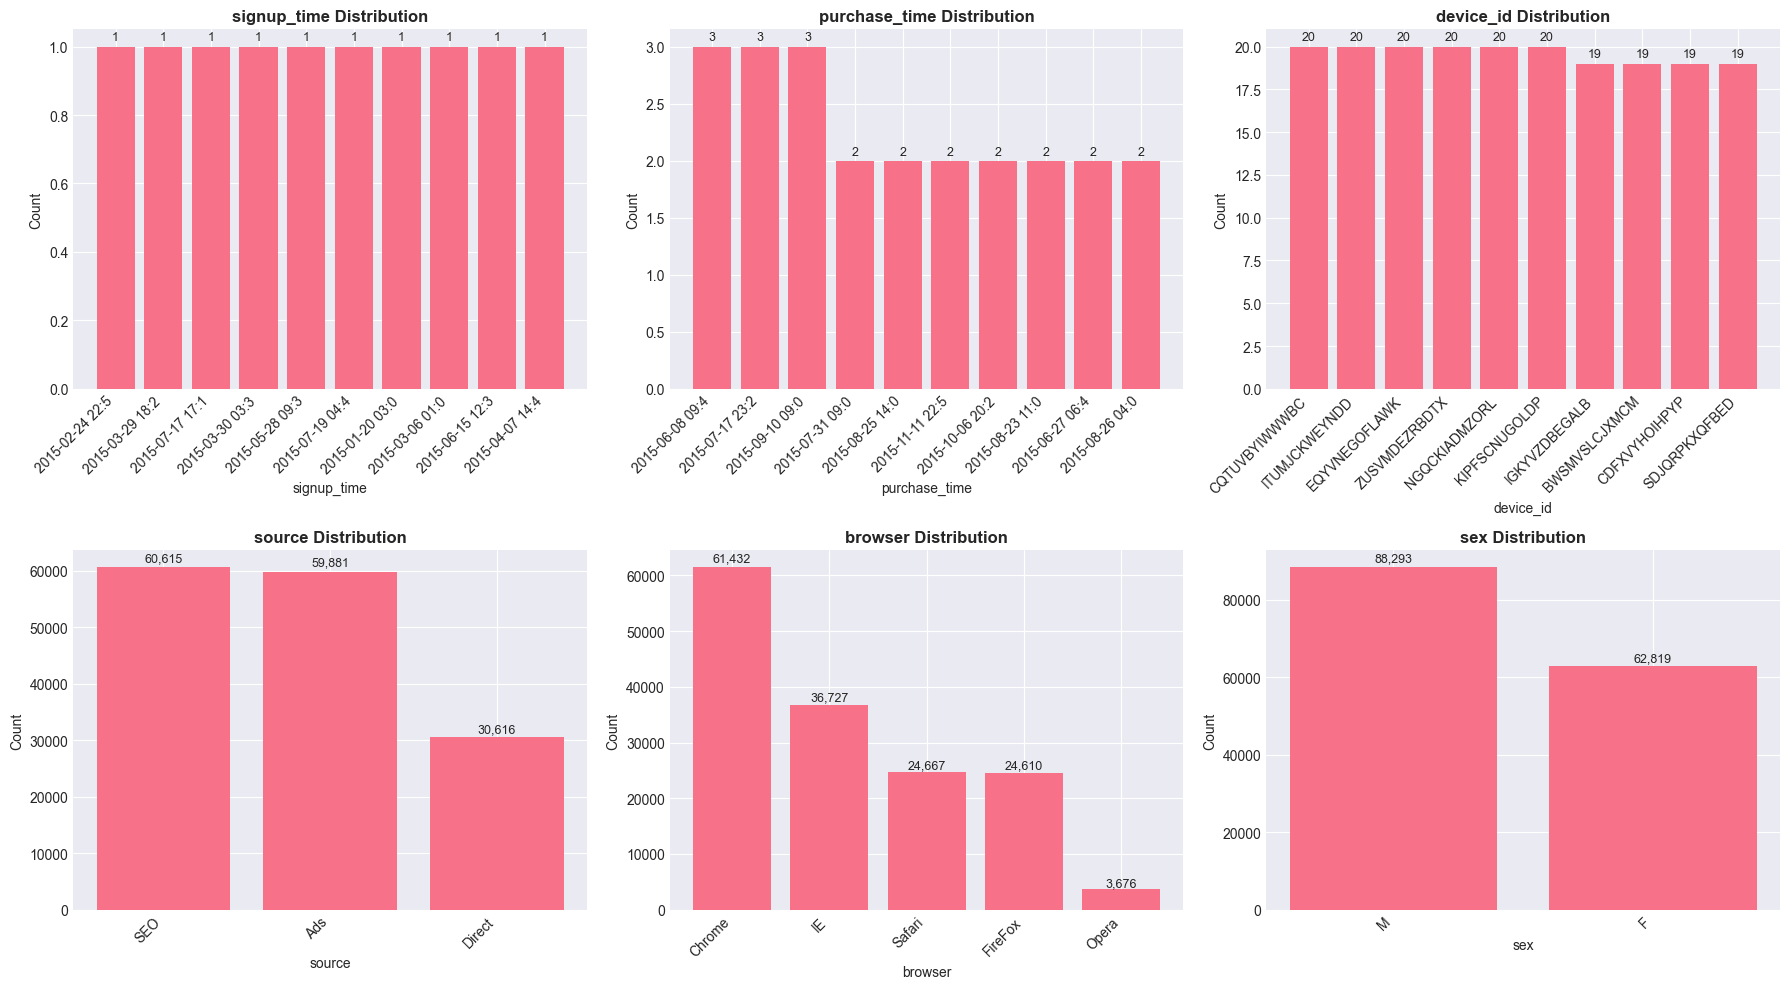


BIVARIATE ANALYSIS WITH TARGET

📈 NUMERICAL FEATURES vs TARGET (4 features):


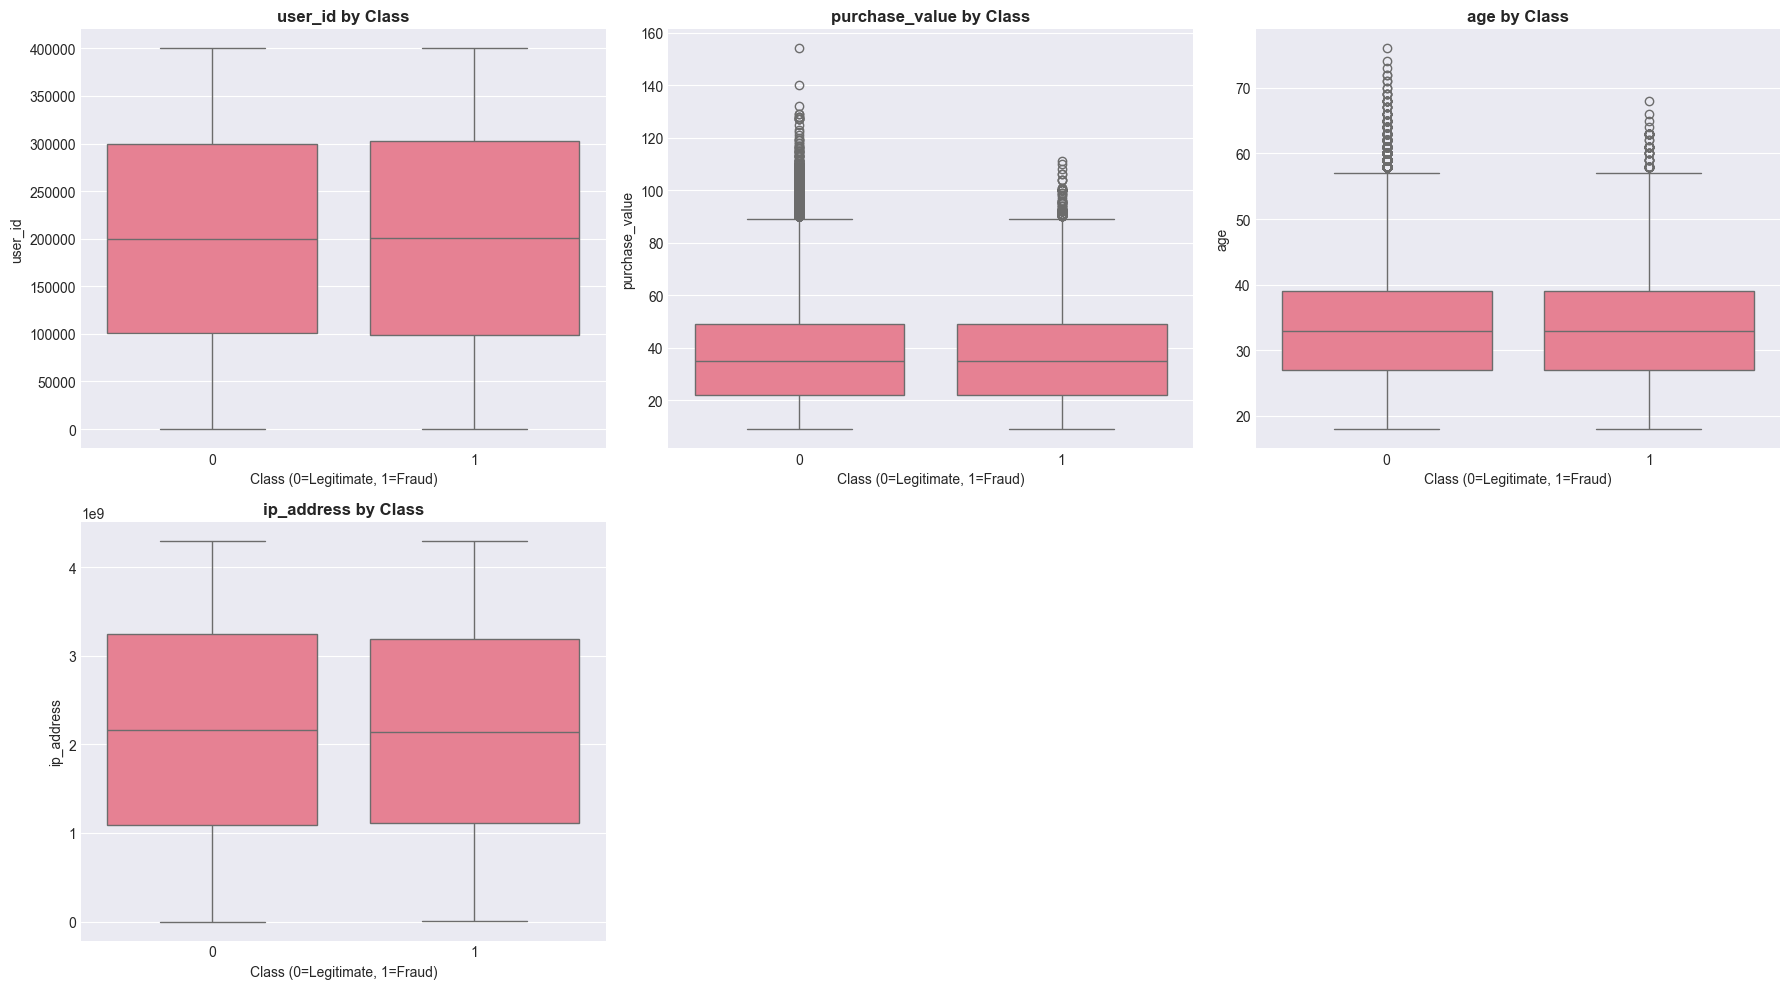


📊 CORRELATION WITH TARGET:
                correlation
age                  0.0066
ip_address          -0.0052
user_id              0.0019
purchase_value       0.0010

📊 CATEGORICAL FEATURES vs TARGET (6 features):


In [ ]:
# Step 2: Exploratory Data Analysis
print("\n" + "="*80)
print("STEP 2: EXPLORATORY DATA ANALYSIS (EDA)")
print("="*80)

# Initialize EDA
eda = FraudEDA(figsize=(12, 8))

# 2.1 Class Distribution Analysis
class_stats = eda.analyze_class_distribution(df_fraud_clean, target_col='class')

# 2.2 Univariate Analysis
eda.univariate_analysis(df_fraud_clean)

# 2.3 Bivariate Analysis
eda.bivariate_analysis(df_fraud_clean, target_col='class')

# 2.4 Correlation Analysis
eda.correlation_analysis(df_fraud_clean)

# 2.5 Outlier Analysis
eda.outlier_analysis(df_fraud_clean)

# Generate EDA report
eda_report = eda.generate_eda_report()

In [ ]:
# Step 3: Geolocation Integration
print("\n" + "="*80)
print("STEP 3: GEOLOCATION INTEGRATION")
print("="*80)

# Initialize geolocation mapper
geo_mapper = IPGeolocationMapper()

# Load IP-to-country mapping
ip_mapping_path = '../data/raw/IpAddress_to_Country.csv'
geo_mapper.load_ip_country_mapping(ip_mapping_path)

# Map IP addresses to countries
df_fraud_geo = df_fraud_clean.copy()
df_fraud_geo['country'] = geo_mapper.map_ips_to_countries(df_fraud_geo['ip_address'])

# Analyze fraud by country
fraud_by_country = geo_mapper.analyze_fraud_by_country(df_fraud_geo, ip_col='ip_address')

# Validate mapping
geo_mapper.validate_mapping()

In [ ]:
# Step 4: Feature Engineering
print("\n" + "="*80)
print("STEP 4: FEATURE ENGINEERING")
print("="*80)

# Initialize feature engineer
feature_engineer = FraudFeatureEngineer(verbose=True)

# Create all features
df_fraud_features = feature_engineer.create_all_features(df_fraud_geo, target_col='class')

# Display feature statistics
print(f"\n📈 Feature Engineering Statistics:")
print(feature_engineer.feature_stats)

# Analyze feature importance
importance_report = feature_engineer.get_feature_importance_report(
    df_fraud_features, target_col='class', top_n=20
)

# Save engineered data
output_path = '../data/processed/fraud_data_engineered.csv'
df_fraud_features.to_csv(output_path, index=False)
print(f"\n💾 Engineered data saved to: {output_path}")
print(f"   Shape: {df_fraud_features.shape}")

In [ ]:
# Step 5: Data Transformation
print("\n" + "="*80)
print("STEP 5: DATA TRANSFORMATION")
print("="*80)

# Initialize transformer
transformer = FraudDataTransformer(random_state=42, verbose=True)

# Run complete transformation pipeline
transformed_data = transformer.full_pipeline(
    df=df_fraud_features,
    target_col='class',
    normalize_method='standard',
    encode_method='label',
    imbalance_method='smote',
    test_size=0.2
)

# Display transformation results
X_train = transformed_data['X_train']
X_test = transformed_data['X_test']
y_train = transformed_data['y_train']
y_test = transformed_data['y_test']

print(f"\n✅ Transformation Complete:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train fraud rate: {y_train.mean():.4f}")
print(f"y_test fraud rate: {y_test.mean():.4f}")

# Save transformed data
train_output = '../data/processed/X_train.csv'
test_output = '../data/processed/X_test.csv'
pd.DataFrame(X_train).to_csv(train_output, index=False)
pd.DataFrame(X_test).to_csv(test_output, index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

print(f"\n💾 Transformed data saved to data/processed/")